In [619]:
import pandas as pd
from IPython.display import display

from gensim.models import KeyedVectors, Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

from sklearn.decomposition import PCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
from numpy.linalg import norm

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

STOP_WORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexanderkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [620]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [659]:
def most_similar(models, keywords):
    # cols = ['1st Similar', '2nd Similar', '3rd Similar', '4th Similar', '5th Similar',
    #         '1st Distance', '2nd Distance', '3rd Distance', '4th Distance', '5th Distance']
    for word in keywords:
        word_df = {}
        for model in models:
            model_name = namestr(model, globals())[0]
            similar = model.wv.most_similar(positive=[word], topn=5)
            
            similar_words = [x[0] for x in similar]
            similar_dists = [round(x[1], 3) for x in similar]
            
            word_df[f'{model_name}_words'] = similar_words
            word_df[f'{model_name}_dists'] = similar_dists
            
        word_df = pd.DataFrame(word_df)
        word_df.columns = ['Pretrained', 'Dists', 'Al Jazeera', 'Dists',
                            'NYT Oct', 'Dists', 'NYT Nov', 'Dists']
        print(f"Similar Words for Keyword: {word}")
        display(word_df)
        print('\n')
    
    return

In [622]:
def plot_with_plotly(x_vals, y_vals, labels, colors, filename, title):
    unique_colors = list(set(colors))
    traces = []

    for color in unique_colors:
        indices = [i for i, c in enumerate(colors) if c == color]
        trace = go.Scatter(x=[x_vals[i] for i in indices], 
                           y=[y_vals[i] for i in indices], 
                           mode='markers',
                           marker=dict(size=4, color=color),
                           text=[labels[i] for i in indices],
                           name=color)
        traces.append(trace)

   #  init_notebook_mode(connected=True)
    layout = go.Layout(title=title, showlegend=True)
    fig = go.Figure(data=traces, layout=layout)
    plot(fig, filename=filename)
    


In [623]:
def reduce_dimensions(model, common_vocab, keywords):
    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings
    
    # filter out unique vocab words
    vectors_fltr, labels_fltr = [], []
    for i, lbl in enumerate(labels):
        if lbl in common_vocab:
            vectors_fltr.append(vectors[i])
            labels_fltr.append(labels[i])

    # reduce using PCA
    pca = PCA(n_components=80)
    # X_sparse = sparse.csr_matrix(vectors)
    pca_vectors = pca.fit_transform(vectors_fltr)
    
    # reduce using t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_vectors = tsne.fit_transform(pca_vectors)

    x_vals = [v[0] for v in tsne_vectors]
    y_vals = [v[1] for v in tsne_vectors]
    
    colors = ['crimson' if lbl in keywords else 'blue' for lbl in labels_fltr]
     
    return x_vals, y_vals, labels_fltr, colors


In [624]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.last_loss = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss-self.last_loss))
        self.last_loss = loss
        self.epoch += 1

In [625]:
DIM = 100

pretrained_path = f"../models/glove.6B/glove_6B_{DIM}d_model.txt"
aljaz_model_name = f'../models/aljaz_2.model'
nyt_oct_model_name = f'../models/nyt_oct_2.model'
nyt_nov_model_name = f'../models/nyt_nov_2.model'

aljaz_data_path = f"../data/Aljaz_text_data_cleaned.csv"
nyt_oct_data_path = f"../data/NYT_text_data_cleaned.csv"
nyt_nov_data_path = f"../data/NYT_text_data_Nov_cleaned.csv"

In [626]:
aljaz_data = pd.read_csv(aljaz_data_path)
nyt_oct_data = pd.read_csv(nyt_oct_data_path)
nyt_nov_data = pd.read_csv(nyt_nov_data_path)

In [627]:
w = 'Palestinian'
w = LEMMATIZER.lemmatize(w)
print(w)

Palestinian


In [628]:
def vocab_counts(data): # send in full_text data
    d = {}
        
    for line in data:
        sents = nltk.sent_tokenize(line)
        for sent in sents:
            words = sent.split(' ')
            for word in words:
                word = TOKENIZER.tokenize(word.lower())
                
                for w in word:
                    if w not in STOP_WORDS:
                        # w = LEMMATIZER.lemmatize(w)
                        if w in d:  d[w] = d[w] + 1
                        else:       d[w] = 1
    return d

In [629]:
def find_word(data, word):
    for line in data:
        sents = nltk.sent_tokenize(line)
        for sent in sents:
            if word in sent:
                print(sent, '\n\n')
    return
    

In [630]:
aljaz_vocab = vocab_counts(aljaz_data['full_text'])
aljaz_vocab = {k: round(v/len(aljaz_vocab.keys()), 3) for (k, v) in aljaz_vocab.items()}
aljaz_vocab = sorted(aljaz_vocab.items(), key=lambda item: item[1], reverse=True)
aljaz_vocab_df = pd.DataFrame(aljaz_vocab[:10], columns=['Al Jazeera Words', 'Frequency'])

nyto_vocab = vocab_counts(nyt_oct_data['full_text'])
nyto_vocab = {k: round(v/len(nyto_vocab.keys()), 3) for (k, v) in nyto_vocab.items()}
nyto_vocab = sorted(nyto_vocab.items(), key=lambda item: item[1], reverse=True)
nyto_vocab_df = pd.DataFrame(nyto_vocab[:10], columns=['NYT Oct Words', 'Frequency'])

nytn_vocab = vocab_counts(nyt_nov_data['full_text'])
nytn_vocab = {k: round(v/len(nytn_vocab.keys()), 3) for (k, v) in nytn_vocab.items()}
nytn_vocab = sorted(nytn_vocab.items(), key=lambda item: item[1], reverse=True)
nytn_vocab_df = pd.DataFrame(nytn_vocab[:10], columns=['NYT Nov Words', 'Frequency'])

In [631]:
word = 'idf'

for i, (w, v) in enumerate(aljaz_vocab):
    if w == word: print(i)
    

1685


In [632]:
pd.concat([aljaz_vocab_df, nyto_vocab_df, nytn_vocab_df], axis=1)

,Al Jazeera Words,Frequency,NYT Oct Words,Frequency,NYT Nov Words,Frequency
0,israel,0.155,israel,0.191,israel,0.138
1,gaza,0.150,gaza,0.123,said,0.117
2,israeli,0.121,said,0.123,hamas,0.095
3,palestinian,0.101,hamas,0.118,gaza,0.090
4,said,0.094,israeli,0.093,israeli,0.078
5,hamas,0.089,people,0.080,people,0.064
6,palestinians,0.069,mr,0.065,mr,0.062
7,al,0.056,one,0.057,one,0.053
8,people,0.053,war,0.054,would,0.053
9,war,0.042,would,0.051,palestinian,0.051


In [633]:
find_word(aljaz_data['full_text'], 'least')

At least 1,200 people were killed in that attack. 


Over the next seven weeks, Israel went on to drop more than 40,000 tonnes of explosives on Gaza, killing more than 15,000 people, including at least 6,150 children, and levelled entire neighbourhoods. 


The Biden administration has called for “humanitarian pauses” in the war while firmly rejecting demands for a ceasefire, at least until Israel achieves its stated goal of eliminating Hamas. 


There have been reports of Jewish Israeli activists being targeted by right-wing mobs with what appears to be at least a tacit approval by the state. 


Hamas fighters killed at least 1,200 people during their attack. 


However, according to the government media office in Gaza, as of November 29, the latest casualty figures following Israeli attacks are as follows:

Gaza

Killed: At least 15,000 Including at least: 6,150 children 4,000 women

Injured: At least 36,000 With more than 75 percent of them children and women

Missing: At least 6,800

In [634]:
model_pre = KeyedVectors.load_word2vec_format(pretrained_path, binary=False)

In [635]:
aljaz_model = Word2Vec.load(aljaz_model_name)
nyt_oct_model = Word2Vec.load(nyt_oct_model_name)
nyt_nov_model = Word2Vec.load(nyt_nov_model_name)

In [636]:
og_vocab = list(model_pre.vocab.keys())
aljaz_vocab = list(aljaz_model.wv.vocab.keys())
nyt_oct_vocab = list(nyt_oct_model.wv.vocab.keys())
nyt_nov_vocab = list(nyt_nov_model.wv.vocab.keys())
common_vocab = set(og_vocab) & set(aljaz_vocab) & set(nyt_oct_vocab) & set(nyt_nov_vocab) 

In [637]:
keywords = ['israel', 'palestine', 'gaza', 'hamas', 'apartheid', 
            'right', 'wrong', 'good', 'evil', 
            'violence', 'peace', 'victim', 'home', 
            'kill', 'save', 'friend', 'enemy',
            'palestinian', 'israeli', 'murder',
            'space', 'environment', 'nation', 'people', 'state',
            'defense', 'defend', 'life', 'border', 'trauma', 
            'genocide', 'displacement', 'invasion',
            'people', 'said', 'one', 'day', 'year', 'would', 'time',
            'territory']

# life, border, trauma, genocide, migration, displacement, invasion

for word in keywords:
    if word not in common_vocab: print(f"{word} not in vocab")

In [660]:
most_similar([model_pre, aljaz_model, nyt_oct_model, nyt_nov_model], keywords)

Similar Words for Keyword: israel


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,israeli,0.855,israeli,0.767,israeli,0.755,israeli,0.751
1,palestinians,0.809,netanyahu,0.707,syria,0.684,palestinian,0.683
2,palestinian,0.785,syria,0.702,palestinian,0.663,syria,0.674
3,lebanon,0.781,lebanon,0.691,lebanon,0.657,lebanon,0.668
4,syria,0.778,palestinian,0.659,netanyahu,0.642,gaza,0.643




Similar Words for Keyword: palestine


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,israel,0.697,plo,0.653,liberation,0.667,liberation,0.657
1,plo,0.693,liberation,0.639,jerusalem,0.636,arab,0.636
2,arab,0.685,arab,0.612,arab,0.630,jerusalem,0.618
3,jerusalem,0.681,zionist,0.597,golan,0.585,lebanon,0.610
4,lebanon,0.673,lebanon,0.578,syria,0.583,palestinian,0.589




Similar Words for Keyword: gaza


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,palestinian,0.843,rafah,0.759,rafah,0.781,rafah,0.763
1,palestinians,0.803,strip,0.752,strip,0.751,strip,0.755
2,strip,0.800,palestinian,0.725,palestinian,0.732,hamas,0.733
3,rafah,0.792,nablus,0.713,jenin,0.700,palestinian,0.733
4,hamas,0.792,jenin,0.710,hamas,0.699,jenin,0.705




Similar Words for Keyword: hamas


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,fatah,0.883,fatah,0.847,fatah,0.831,fatah,0.830
1,palestinian,0.830,militant,0.757,palestinian,0.739,militant,0.755
2,militant,0.807,hezbollah,0.750,militant,0.733,gaza,0.733
3,abbas,0.799,abbas,0.749,abbas,0.709,palestinian,0.725
4,hezbollah,0.793,islamist,0.734,islamist,0.701,hezbollah,0.725




Similar Words for Keyword: apartheid


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,dictatorship,0.671,colonialism,0.653,slavery,0.641,oppression,0.610
1,colonialism,0.643,regime,0.607,oppression,0.610,racism,0.608
2,slavery,0.640,brutal,0.545,racism,0.610,regime,0.608
3,mandela,0.627,repression,0.540,regime,0.605,communism,0.558
4,anc,0.616,democracy,0.536,brutal,0.546,dictator,0.555




Similar Words for Keyword: right


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,if,0.775,left,0.685,left,0.678,left,0.665
1,back,0.773,back,0.667,back,0.632,shoulder,0.599
2,left,0.768,put,0.648,hard,0.632,position,0.595
3,way,0.759,wrong,0.642,put,0.622,wing,0.588
4,put,0.756,way,0.639,shoulder,0.621,forward,0.587


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).





Similar Words for Keyword: wrong


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,mistake,0.788,anything,0.784,mistake,0.775,mistake,0.777
1,anything,0.784,nothing,0.773,anything,0.763,anything,0.770
2,nothing,0.774,think,0.768,guess,0.757,guess,0.754
3,think,0.774,thing,0.765,sure,0.746,nothing,0.744
4,thing,0.767,know,0.759,nothing,0.738,think,0.740


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: good


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,better,0.893,better,0.891,better,0.867,better,0.862
1,sure,0.831,sure,0.825,sure,0.797,sure,0.807
2,really,0.830,really,0.823,really,0.784,excellent,0.801
3,kind,0.829,kind,0.820,best,0.779,really,0.786
4,very,0.826,think,0.810,always,0.768,best,0.777


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: evil


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,enemies,0.718,god,0.670,god,0.660,god,0.667
1,god,0.668,true,0.639,villain,0.651,true,0.644
2,demons,0.665,murderous,0.625,murderous,0.629,murderous,0.627
3,beings,0.665,hell,0.600,true,0.625,cruel,0.618
4,wicked,0.661,enemy,0.587,cruel,0.619,hell,0.594


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: violence


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,violent,0.807,bloodshed,0.790,bloodshed,0.796,bloodshed,0.795
1,bloodshed,0.796,violent,0.788,violent,0.774,violent,0.781
2,clashes,0.770,unrest,0.741,unrest,0.733,escalating,0.670
3,unrest,0.759,conflict,0.705,conflict,0.679,fighting,0.657
4,conflict,0.756,escalating,0.671,escalating,0.674,conflict,0.653


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: peace


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,reconciliation,0.777,reconciliation,0.779,accord,0.746,reconciliation,0.776
1,accord,0.757,accord,0.752,unity,0.721,accord,0.745
2,talks,0.744,unity,0.738,ceasefire,0.710,unity,0.720
3,unity,0.738,progress,0.717,progress,0.699,ceasefire,0.703
4,ceasefire,0.731,ceasefire,0.705,agreement,0.673,progress,0.687


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: victim


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,victims,0.731,man,0.696,woman,0.690,murder,0.686
1,woman,0.724,witness,0.694,murder,0.689,witness,0.684
2,child,0.711,murder,0.690,child,0.684,suspect,0.677
3,man,0.708,woman,0.686,witness,0.681,perpetrator,0.668
4,murder,0.700,suspect,0.679,suspect,0.679,man,0.660




Similar Words for Keyword: home


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,away,0.743,away,0.683,away,0.663,away,0.655
1,where,0.742,went,0.680,went,0.650,went,0.650
2,went,0.739,back,0.649,family,0.628,moved,0.637
3,back,0.733,moved,0.645,apartment,0.626,couple,0.635
4,out,0.729,run,0.642,stay,0.621,hometown,0.630




Similar Words for Keyword: kill


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,killing,0.731,killing,0.718,killing,0.697,killing,0.712
1,kills,0.710,destroy,0.701,destroy,0.691,destroy,0.699
2,destroy,0.704,attack,0.637,shoot,0.675,shoot,0.677
3,shoot,0.680,dead,0.625,killed,0.610,poison,0.639
4,attack,0.664,killed,0.625,suicide,0.600,killed,0.623


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: save


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,saved,0.770,help,0.704,saved,0.769,saved,0.767
1,saving,0.750,put,0.686,help,0.683,saving,0.746
2,help,0.706,chance,0.663,put,0.665,help,0.680
3,put,0.701,give,0.652,chance,0.659,put,0.664
4,chance,0.667,try,0.647,bring,0.647,chance,0.655


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: friend


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,father,0.836,father,0.831,father,0.826,wife,0.809
1,wife,0.830,wife,0.826,wife,0.819,father,0.804
2,husband,0.827,husband,0.822,husband,0.818,husband,0.800
3,brother,0.815,brother,0.812,brother,0.799,brother,0.783
4,friends,0.800,son,0.785,uncle,0.779,uncle,0.771


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: enemy


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,enemies,0.737,allied,0.653,allied,0.650,allied,0.651
1,forces,0.702,destroy,0.651,destroy,0.646,destroy,0.641
2,allied,0.655,attacking,0.629,combat,0.612,attacking,0.623
3,destroy,0.653,combat,0.625,attacking,0.610,combat,0.610
4,attack,0.649,attack,0.621,battlefield,0.607,battlefield,0.607


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: palestinian


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,israeli,0.884,israeli,0.812,israeli,0.811,israeli,0.813
1,palestinians,0.879,gaza,0.725,hamas,0.739,gaza,0.733
2,gaza,0.843,hamas,0.709,gaza,0.732,hamas,0.725
3,hamas,0.830,lebanese,0.701,lebanese,0.696,lebanese,0.694
4,arafat,0.785,plo,0.690,fatah,0.694,fatah,0.684




Similar Words for Keyword: israeli


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,palestinian,0.884,palestinian,0.812,palestinian,0.811,palestinian,0.813
1,israel,0.855,israel,0.767,israel,0.755,israel,0.751
2,palestinians,0.802,lebanese,0.716,lebanese,0.706,lebanese,0.738
3,israelis,0.792,netanyahu,0.655,gaza,0.656,gaza,0.664
4,lebanese,0.778,syrian,0.641,syrian,0.650,syrian,0.662




Similar Words for Keyword: murder


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,slaying,0.828,convicted,0.787,rape,0.815,rape,0.814
1,murders,0.819,conviction,0.749,kidnapping,0.798,kidnapping,0.795
2,rape,0.811,trial,0.748,conviction,0.747,convicted,0.790
3,kidnapping,0.795,charged,0.739,trial,0.745,conviction,0.748
4,convicted,0.787,criminal,0.727,guilty,0.738,trial,0.744


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: space


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,nasa,0.704,earth,0.669,earth,0.658,earth,0.654
1,spaces,0.688,center,0.599,surface,0.594,surface,0.595
2,shuttle,0.681,project,0.598,design,0.594,complex,0.585
3,earth,0.673,complex,0.593,discovery,0.593,design,0.581
4,spacecraft,0.663,mission,0.592,project,0.589,solar,0.580


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: environment


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,climate,0.760,climate,0.756,climate,0.761,climate,0.751
1,development,0.735,development,0.730,development,0.724,development,0.725
2,environmental,0.727,environmental,0.723,resource,0.640,sustainable,0.692
3,environments,0.721,sustainable,0.693,protection,0.634,resource,0.651
4,sustainable,0.693,social,0.661,social,0.634,social,0.639




Similar Words for Keyword: nation


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,country,0.876,country,0.839,country,0.811,country,0.823
1,america,0.778,america,0.748,america,0.704,continent,0.707
2,continent,0.723,state,0.695,state,0.701,america,0.694
3,world,0.715,populous,0.670,largest,0.631,state,0.676
4,states,0.712,largest,0.659,biggest,0.622,largest,0.639




Similar Words for Keyword: people


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,others,0.832,others,0.778,others,0.711,others,0.706
1,those,0.805,many,0.740,many,0.695,many,0.680
2,many,0.797,least,0.670,ordinary,0.636,ordinary,0.629
3,some,0.775,say,0.669,thousand,0.624,thousand,0.611
4,they,0.772,dead,0.648,dead,0.620,dead,0.610




Similar Words for Keyword: state


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,federal,0.743,nation,0.695,nation,0.701,nation,0.676
1,states,0.743,national,0.662,federal,0.640,federal,0.619
2,national,0.718,california,0.643,oregon,0.608,texas,0.610
3,government,0.713,administration,0.639,texas,0.603,arizona,0.600
4,nation,0.703,congress,0.616,national,0.594,ohio,0.577




Similar Words for Keyword: defense


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,defence,0.852,defence,0.847,intelligence,0.605,intelligence,0.630
1,military,0.686,intelligence,0.655,pentagon,0.605,pentagon,0.621
2,force,0.665,military,0.640,military,0.603,military,0.615
3,intelligence,0.656,force,0.634,force,0.598,force,0.614
4,security,0.650,administration,0.631,army,0.584,army,0.610


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: defend


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,protect,0.735,protect,0.737,protect,0.733,protect,0.729
1,fight,0.679,fight,0.678,fight,0.672,defending,0.670
2,defending,0.674,maintain,0.632,defending,0.668,defended,0.666
3,defended,0.666,destroy,0.625,defended,0.666,fight,0.662
4,against,0.663,abandon,0.611,maintain,0.628,maintain,0.627




Similar Words for Keyword: life


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,lives,0.790,mind,0.717,experience,0.668,experience,0.646
1,man,0.737,experience,0.711,history,0.656,love,0.640
2,well,0.734,love,0.711,love,0.645,history,0.639
3,mind,0.733,history,0.696,nature,0.643,mind,0.633
4,years,0.732,nature,0.689,mind,0.621,living,0.630




Similar Words for Keyword: border


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,borders,0.771,crossing,0.719,crossing,0.741,crossing,0.745
1,territory,0.750,territory,0.678,territory,0.709,territory,0.729
2,crossing,0.742,northern,0.675,northern,0.687,northern,0.686
3,frontier,0.721,along,0.638,patrol,0.666,patrol,0.657
4,northern,0.710,southern,0.615,along,0.654,along,0.650


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: trauma


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,mental,0.735,pain,0.711,mental,0.735,traumatic,0.730
1,traumatic,0.726,psychological,0.650,traumatic,0.732,mental,0.725
2,pain,0.710,suffering,0.649,pain,0.715,pain,0.711
3,psychiatric,0.670,stress,0.633,suffering,0.651,suffering,0.654
4,suffering,0.650,shock,0.619,psychological,0.648,psychological,0.644


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: genocide


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,crimes,0.772,humanity,0.688,humanity,0.691,complicity,0.692
1,atrocities,0.771,massacre,0.661,complicity,0.689,humanity,0.675
2,massacres,0.721,murder,0.615,massacre,0.669,rwanda,0.665
3,humanity,0.690,genocidal,0.608,murder,0.617,massacre,0.660
4,complicity,0.689,cleansing,0.607,cleansing,0.605,cleansing,0.613


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: displacement


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,displacements,0.740,resulting,0.544,resulting,0.554,resulting,0.547
1,acceleration,0.579,displaced,0.536,displaced,0.536,displaced,0.539
2,velocity,0.567,constant,0.498,constant,0.503,constant,0.505
3,load,0.557,width,0.478,weight,0.473,engine,0.504
4,resulting,0.549,scale,0.460,capacity,0.464,weight,0.471




Similar Words for Keyword: invasion


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,u.s.-led,0.756,occupation,0.721,occupation,0.708,occupation,0.730
1,occupation,0.755,war,0.717,invaded,0.690,invaded,0.714
2,war,0.743,invaded,0.713,invading,0.683,war,0.703
3,invaded,0.716,iraq,0.652,war,0.649,iraq,0.646
4,invading,0.704,allied,0.638,iraq,0.615,allied,0.636


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: people


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,others,0.832,others,0.778,others,0.711,others,0.706
1,those,0.805,many,0.740,many,0.695,many,0.680
2,many,0.797,least,0.670,ordinary,0.636,ordinary,0.629
3,some,0.775,say,0.669,thousand,0.624,thousand,0.611
4,they,0.772,dead,0.648,dead,0.620,dead,0.610


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: said


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,told,0.849,told,0.792,told,0.778,told,0.781
1,says,0.816,spokesman,0.741,spokesman,0.693,spokesman,0.700
2,saying,0.789,added,0.738,added,0.675,added,0.675
3,added,0.783,asked,0.726,warned,0.645,spokeswoman,0.654
4,asked,0.776,saying,0.714,saying,0.642,adding,0.648


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: one


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,only,0.909,another,0.841,another,0.816,another,0.801
1,another,0.904,two,0.816,four,0.776,three,0.749
2,this,0.872,three,0.811,three,0.774,two,0.739
3,same,0.865,five,0.797,five,0.772,four,0.734
4,two,0.864,four,0.790,two,0.748,five,0.733


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: day


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,days,0.886,week,0.815,week,0.790,week,0.779
1,week,0.852,weekend,0.801,month,0.773,weekend,0.772
2,next,0.832,month,0.783,weekend,0.769,month,0.758
3,time,0.828,night,0.781,afternoon,0.721,afternoon,0.746
4,night,0.826,next,0.775,morning,0.719,hour,0.742


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: year


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,last,0.904,month,0.843,month,0.829,month,0.812
1,month,0.893,last,0.825,ago,0.754,ago,0.734
2,years,0.876,ago,0.801,week,0.752,1995,0.729
3,months,0.876,2000,0.776,last,0.749,week,0.721
4,since,0.860,2005,0.770,1995,0.740,last,0.712


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: would


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,could,0.952,could,0.915,could,0.880,could,0.894
1,will,0.929,might,0.869,might,0.831,might,0.840
2,not,0.927,must,0.827,must,0.796,must,0.808
3,should,0.917,make,0.821,likely,0.774,likely,0.768
4,be,0.903,decided,0.810,decided,0.760,expected,0.760


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: time


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,when,0.861,start,0.779,start,0.696,start,0.681
1,this,0.854,first,0.768,first,0.694,starting,0.670
2,before,0.853,next,0.767,starting,0.693,period,0.659
3,but,0.849,way,0.752,early,0.689,early,0.656
4,only,0.848,even,0.748,period,0.687,first,0.649


<ipython-input-659-90a475133e62>:8: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Similar Words for Keyword: territory


,Pretrained,Dists,Al Jazeera,Dists,NYT Oct,Dists,NYT Nov,Dists
0,territories,0.824,border,0.678,occupied,0.710,border,0.729
1,border,0.750,sovereignty,0.669,border,0.709,occupied,0.716
2,occupied,0.717,land,0.669,enclave,0.699,northern,0.692
3,northern,0.712,territorial,0.668,land,0.692,enclave,0.691
4,frontier,0.711,enclave,0.659,northern,0.686,territorial,0.678


In [639]:
# compute cos similarity
# sort by most different

distances = {}
for word in common_vocab:
    pre, aj, nyt_o, nyt_n = model_pre[word], aljaz_model.wv[word], nyt_oct_model.wv[word], nyt_nov_model.wv[word]
    aj_cos = np.dot(pre, aj) / (norm(pre) * norm(aj))
    nyt_o_cos = np.dot(pre, nyt_o) / (norm(pre) * norm(nyt_o))
    nyt_n_cos = np.dot(pre, nyt_n) / (norm(pre) * norm(nyt_n))
    distances[word] = [aj_cos, nyt_o_cos, nyt_n_cos]

distances = dict(sorted(distances.items(), key=lambda item: sum(item[1])))
    

In [640]:
columns=['Word', 'AJ', 'NYT O', 'NYT N']
change_df = pd.DataFrame.from_dict(distances, orient='index',
                                   columns=['Al Jazeera', 'NYT October', 'NYT November'])
change_df.loc['Mean of Distances'] = change_df.mean(axis=0)
change_df.tail(1)

,Al Jazeera,NYT October,NYT November
Mean of Distances,0.998529,0.995386,0.995032


In [641]:
change_df[: 10]

,Al Jazeera,NYT October,NYT November
israel,0.937365,0.879018,0.880334
one,0.963569,0.892993,0.869109
said,0.971969,0.879560,0.890485
time,0.974002,0.898127,0.889892
day,0.960585,0.906566,0.899342
israeli,0.948649,0.909595,0.914539
year,0.970075,0.911993,0.896664
palestinian,0.930660,0.924841,0.926111
people,0.959925,0.922074,0.910683
would,0.972288,0.913788,0.918723


In [642]:
df_aj = change_df.sort_values(by='Al Jazeera').reset_index()
del df_aj['NYT November']; del df_aj['NYT October']
df_nyto = change_df.sort_values(by='NYT October').reset_index()
del df_nyto['NYT November']; del df_nyto['Al Jazeera']
df_nytn = change_df.sort_values(by='NYT November').reset_index()
del df_nytn['Al Jazeera']; del df_nytn['NYT October']


In [646]:
pd.concat([df_aj[:10], df_nyto[:10], df_nytn[:10]], axis=1)

,index,Al Jazeera,index,NYT October,index,NYT November
0,palestinian,0.930660,israel,0.879018,one,0.869109
1,israel,0.937365,said,0.879560,israel,0.880334
2,gaza,0.942964,one,0.892993,time,0.889892
3,israeli,0.948649,time,0.898127,said,0.890485
4,people,0.959925,attack,0.905167,year,0.896664
5,day,0.960585,day,0.906566,day,0.899342
6,one,0.963569,israeli,0.909595,even,0.900347
7,hamas,0.966385,year,0.911993,people,0.910683
8,according,0.966755,would,0.913788,say,0.911543
9,attack,0.969402,even,0.921090,israeli,0.914539


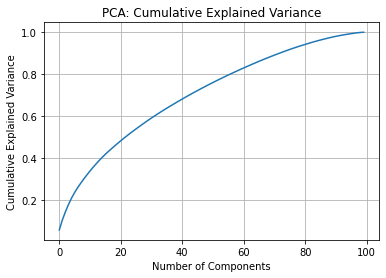

In [647]:
# test dim reduction
pca = PCA()
pca.fit(np.asarray(nyt_nov_model.wv.vectors))

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [648]:
pre_x, pre_y, pre_lbl, pre_colors = reduce_dimensions(model_pre, common_vocab, keywords)

<ipython-input-623-a8a939778a5d>:3: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

<ipython-input-623-a8a939778a5d>:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [649]:
aj_x, aj_y, aj_lbl, aj_colors = reduce_dimensions(aljaz_model, common_vocab, keywords)

In [650]:
nyt_oct_x, nyt_oct_y, nyt_oct_lbl, nyt_oct_colors = reduce_dimensions(nyt_oct_model, common_vocab, keywords)

In [651]:
nyt_nov_x, nyt_nov_y, nyt_nov_lbl, nyt_nov_colors = reduce_dimensions(nyt_nov_model, common_vocab, keywords)

In [652]:
plot_with_plotly(pre_x, pre_y, pre_lbl, pre_colors, '../vis/pre_embed.html', 'Pretrained Embeddings')

In [653]:
plot_with_plotly(aj_x, aj_y, aj_lbl, aj_colors, '../vis/aj_embed.html', 'Al Jazeera Embeddings')

In [654]:
plot_with_plotly(nyt_oct_x, nyt_oct_y, nyt_oct_lbl, nyt_oct_colors, '../vis/nyt_o_embed.html', 'NYT October Embeddings')

In [655]:
plot_with_plotly(nyt_nov_x, nyt_nov_y, nyt_nov_lbl, nyt_nov_colors, '../vis/nyt_n_embed.html', 'NYT November Embeddings')

In [656]:
## AVERAGE WORD EMBEDDINGS PER ARTICLE / CORPUS
## FIND CLOSEST MATCH IN PRETRAINED

## CREATE AXIS WORDS
## PLOT KEY WORDS ON THESE AXES

## LOOK INTO DOUBLE DIMENSIONALITY REDUCTION & PROJECTION